The system consists of two competing reaction pathways (Ruta 1 and Ruta 2), each described by a set of temperature-dependent kinetic equations derived from Arrhenius expressions.

##### Ruta 1
$$
A \xrightarrow{k_1} B \xrightarrow{k_2} C
$$

$C_{A,t}$, $C_{B,t}$, $C_{C,t}$ are the concentration of the species in fuction of time.
$k_{1}$, $k_{2}$ ar ethe kinetic constants


\begin{align*}
\frac{d[C_A]}{dt} &= -k_1 [C_A]  \\
\frac{d[C_B]}{dt} &= k_1 [C_A] - k_2 [C_B] \\
\frac{d[C_C]}{dt} &= k_2 [C_B] 
\end{align*}


##### Ruta 2
$$
A \xrightarrow{k_3} C \xrightarrow{k_4} D
$$

$C_{A,t}$, $C_{C,t}$, $C_{D,t}$ are the concentration of the species in fuction of time.
$k_{3}$, $k_{4}$, $k_{5}$ ar ethe kinetic constants


\begin{align*}
\frac{d[C_A]}{dt} &= -k_3 [C_A]  \\
\frac{d[C_B]}{dt} &= k_3 [C_A] - k_4 [C_C] \\
\frac{d[C_C]}{dt} &= k_4 [C_D] 
\end{align*}


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "STIXGeneral",
    "text.latex.preamble": r"\usepackage[utf8]{inputenc}\usepackage{amsmath}",
    "figure.figsize": [12, 4],  # ancho, Largo  
    "xtick.labelsize": 12,  # tamaño ticks en eje x
    "ytick.labelsize": 12   # tamaño ticks en eje y
})

import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.integrate import solve_ivp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


In [ ]:
# Kinetic Model
R = 8.314  # J/mol·K

params_r1 = {'A1': 5e3, 'E1': 42000, 'A2': 3e3, 'E2': 35000}
params_r2 = {'A3': 3e3, 'E3': 25000, 'A4': 3e3, 'E4': 40000}

def initial_conditions():
    return [1.0, 0.0, 0.0]  # [A], [B], [C] o [A], [C], [D]

def ode_ruta1(t, y, T):
    A, B, C = y
    k1 = params_r1['A1'] * np.exp(-params_r1['E1'] / (R * T))
    k2 = params_r1['A2'] * np.exp(-params_r1['E2'] / (R * T))
    dA_dt = -k1 * A
    dB_dt = k1 * A - k2 * B
    dC_dt = k2 * B
    return [dA_dt, dB_dt, dC_dt]

def ode_ruta2(t, y, T):
    A, C, D = y
    k3 = params_r2['A3'] * np.exp(-params_r2['E3'] / (R * T))
    k4 = params_r2['A4'] * np.exp(-params_r2['E4'] / (R * T))
    dA_dt = -k3 * A
    dC_dt = k3 * A - k4 * C
    dD_dt = k4 * C
    return [dA_dt, dC_dt, dD_dt]

def evaluate_C_from_indices(t_idx, tau_idx, ruta_idx, T_range, Tau_range):
    T = T_range[t_idx]
    Tau = Tau_range[tau_idx]
    Ruta = ruta_idx + 1
    if Ruta == 1:
        sol = solve_ivp(ode_ruta1, [0, Tau], initial_conditions(), args=(T,), method='LSODA')
        return sol.y[2, -1]
    else:
        sol = solve_ivp(ode_ruta2, [0, Tau], initial_conditions(), args=(T,), method='LSODA')
        return sol.y[1, -1]

# Generate discrete data
n_T = 20     # Temperature
n_Tau = 20   # Time
n_Ruta = 2   # Ruta

T_range = np.linspace(100, 600, n_T)
Tau_range = np.linspace(1, 120, n_Tau)

T_idx, Tau_idx, Ruta_idx, C_final = [], [], [], []

for i in range(n_T):
    for j in range(n_Tau):
        for r in range(n_Ruta):
            C_val = evaluate_C_from_indices(i, j, r, T_range, Tau_range)
            T_idx.append(i)
            Tau_idx.append(j)
            Ruta_idx.append(r)
            C_final.append(C_val)

X_tensor = torch.tensor(np.stack([T_idx, Tau_idx, Ruta_idx], axis=1), dtype=torch.long)
Y_tensor = torch.tensor(C_final, dtype=torch.float32)


Utility functions

In [3]:
def recover_T(i): return T_range[i]
def recover_Tau(j): return Tau_range[j]
def recover_Ruta(k): return k + 1

Variational AutoEncoder Class

In [7]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, n_T, n_Tau, n_Ruta, emb_dims=(16, 16, 4), latent_dim=8):
        super().__init__()
        self.emb_T = nn.Embedding(n_T, emb_dims[0])
        self.emb_Tau = nn.Embedding(n_Tau, emb_dims[1])
        self.emb_Ruta = nn.Embedding(n_Ruta, emb_dims[2])
        self.encoder = nn.Sequential(nn.Linear(sum(emb_dims), 64), nn.ReLU())
        self.mu = nn.Linear(64, latent_dim)
        self.logvar = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 64), nn.ReLU(), nn.Linear(64, sum(emb_dims)))
        self.out_T = nn.Linear(emb_dims[0], n_T)
        self.out_Tau = nn.Linear(emb_dims[1], n_Tau)
        self.out_Ruta = nn.Linear(emb_dims[2], n_Ruta)

    def encode(self, x):
        t, tau, r = x[:, 0], x[:, 1], x[:, 2]
        h = torch.cat([self.emb_T(t), self.emb_Tau(tau), self.emb_Ruta(r)], dim=1)
        h = self.encoder(h)
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std, eps = torch.exp(0.5 * logvar), torch.randn_like(mu)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder(z)
        t_dec, tau_dec, ruta_dec = torch.split(h, [self.emb_T.embedding_dim, self.emb_Tau.embedding_dim, self.emb_Ruta.embedding_dim], dim=1)
        return self.out_T(t_dec), self.out_Tau(tau_dec), self.out_Ruta(ruta_dec)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        t_log, tau_log, ruta_log = self.decode(z)
        return t_log, tau_log, ruta_log, mu, logvar, z


Loss functions 

In [ ]:
def vae3_loss(t_log, tau_log, ruta_log, t, tau, ruta, mu, logvar, beta=0.001):
    ce_t = F.cross_entropy(t_log, t)
    ce_tau = F.cross_entropy(tau_log, tau)
    ce_ruta = F.cross_entropy(ruta_log, ruta)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return ce_t + ce_tau + ce_ruta + beta * kl , ce_t + ce_tau + ce_ruta ,  beta * kl


Train Model

In [8]:
vae =  VariationalAutoEncoder(n_T, n_Tau, n_Ruta)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2)
list_loss_recon = []
list_loss_kl = [] 
list_loss_global = []
for epoch in range(500):
    vae.train()
    optimizer.zero_grad()
    t_log, tau_log, ruta_log, mu, logvar, z = vae(X_tensor)
    loss, loss_recon , loss_kl = vae3_loss(t_log, tau_log, ruta_log,
                     X_tensor[:, 0], X_tensor[:, 1], X_tensor[:, 2],
                     mu, logvar)
    list_loss_recon.append(loss_recon.item())
    list_loss_kl.append(loss_kl.item())
    list_loss_global.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 6.8067
Epoch 50 | Loss: 0.0525
Epoch 100 | Loss: 0.0292
Epoch 150 | Loss: 0.0185
Epoch 200 | Loss: 0.0133
Epoch 250 | Loss: 0.0106
Epoch 300 | Loss: 0.0089
Epoch 350 | Loss: 0.0078
Epoch 400 | Loss: 0.0069
Epoch 450 | Loss: 0.0062


Reconstruct data

In [9]:
# Reconstruct
vae.eval()
with torch.no_grad():
    t_log, tau_log, ruta_log, _, _, z_latent = vae(X_tensor)
    t_pred = torch.argmax(t_log, dim=1).numpy()
    tau_pred = torch.argmax(tau_log, dim=1).numpy()
    ruta_pred = torch.argmax(ruta_log, dim=1).numpy()

    T_rec = np.array([recover_T(i) for i in t_pred])
    Tau_rec = np.array([recover_Tau(j) for j in tau_pred])
    Ruta_rec = np.array([recover_Ruta(k) for k in ruta_pred])
    T_real = np.array([recover_T(i) for i in T_idx])
    Tau_real = np.array([recover_Tau(j) for j in Tau_idx])
    Ruta_real = np.array([recover_Ruta(k) for k in Ruta_idx])
    Z_vals = Y_tensor.numpy()

# Evaluate C_final reconstructed
C_rec = np.array([
    evaluate_C_from_indices(ti, taui, ri, T_range, Tau_range)
    for ti, taui, ri in zip(t_pred, tau_pred, ruta_pred)
])

Plot of how the reconstruction error changes with respect to dimensions

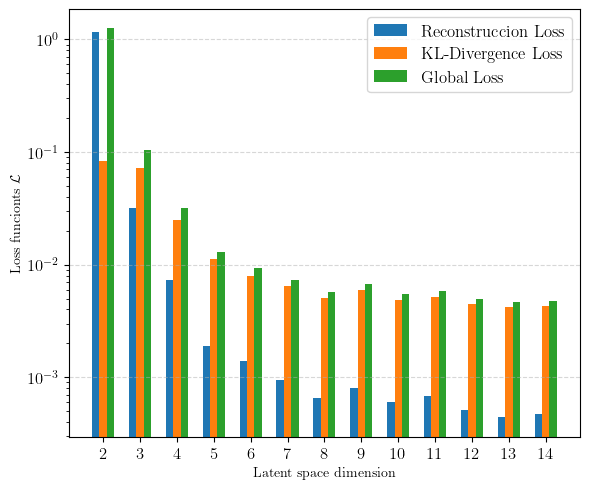

In [11]:
list_loss_recon_dim = []
list_loss_kl_dim = [] 
list_loss_global_dim = []
dimension = 15
for i in range(2,dimension):
    latent_dim_val = i
    vae = VariationalAutoEncoder(n_T, n_Tau, n_Ruta, latent_dim= latent_dim_val)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2)
    for epoch in range(500):
        vae.train()
        optimizer.zero_grad()
        t_log, tau_log, ruta_log, mu, logvar, z = vae(X_tensor)
        loss, loss_recon , loss_kl = vae3_loss(t_log, tau_log, ruta_log,
                        X_tensor[:, 0], X_tensor[:, 1], X_tensor[:, 2],
                        mu, logvar)
        loss.backward()
        optimizer.step()
        # if epoch % 50 == 0:
        #     print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    list_loss_recon_dim.append(loss_recon.item())
    list_loss_kl_dim.append(loss_kl.item())
    list_loss_global_dim.append(loss.item())


# Plot
x = np.arange(2, dimension)
width = 0.20  

# Crear figura
fig = plt.figure(figsize=(6, 5))

# Dibujar barras agrupadas
plt.bar(x - width, (np.array(list_loss_recon_dim)), width, label=  'Reconstruccion Loss')
plt.bar(x,         (np.array(list_loss_kl_dim)), width, label= 'KL-Divergence Loss')
plt.bar(x + width, (np.array(list_loss_global_dim)), width, label="Global Loss")

# Etiquetas y estilo
plt.xlabel("Latent space dimension")
plt.ylabel(r'Loss funcionts $\mathcal{L}$')
# ax.set_title("Comparación de Losses vs Dimensión")
plt.xticks(x)
plt.legend(fontsize= '12', loc = 'upper right')
plt.yscale(value='log')
plt.grid(axis="y", linestyle="--", alpha=0.5)
# Mostrar gráfica

fig.tight_layout()
plt.show()

Generate image to see how reconstruction errors and KLdivergence evolve

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


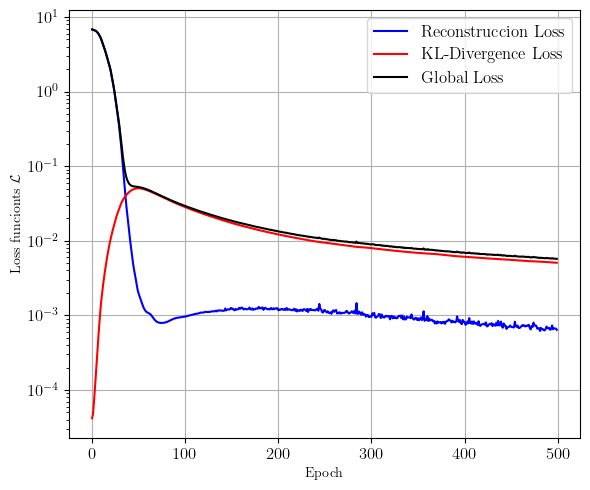

In [ ]:
fig = plt.figure(figsize=(6, 5))
plt.plot(list_loss_recon, c='blue', label = 'Reconstruccion Loss')
plt.plot(list_loss_kl, c='red', label = 'KL-Divergence Loss')
plt.plot(list_loss_global, c ='black', label = 'Global Loss')
plt.ylabel(r'Loss funcionts $\mathcal{L}$')
plt.xlabel(r'Epoch')
plt.grid(True)
plt.legend( fontsize= '12', loc = 'upper right')
plt.yscale(value='log')

fig.tight_layout()
plt.show()

Generate an image that shows that it can be rebuilt

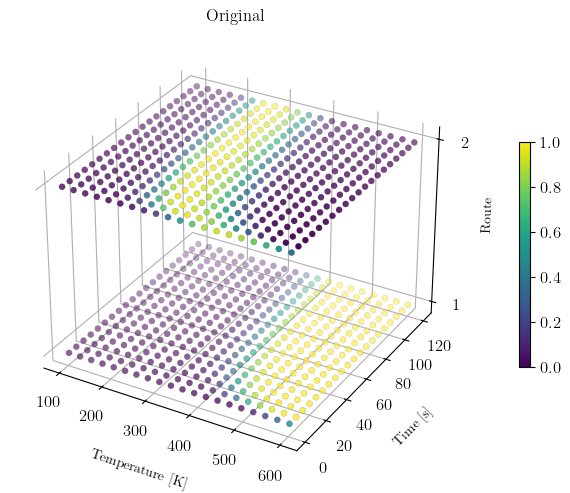

In [ ]:
fig = plt.figure(figsize=(12, 5))
# Original
ax1 = fig.add_subplot(111, projection='3d')
sc1 = ax1.scatter(T_real, Tau_real, Ruta_real, c=Z_vals, cmap='viridis', s=20, edgecolors= 'black', linewidths= 0.1)
ax1.set_title('Original')
ax1.set_xlabel('Temperature [K]', labelpad=10)
ax1.set_ylabel('Time [s]', labelpad=10)
ax1.set_zlabel('Route', labelpad=2)
ax1.set_zticks([1,2])
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
fig.colorbar(sc1, ax=ax1, pad=0.05, shrink = 0.5 )
plt.tight_layout()
plt.show()

C:\Users\gabo1\AppData\Local\Temp\ipykernel_6160\498146566.py:9: UserWarning: Adding colorbar to a different Figure <Figure size 1200x500 with 2 Axes> than <Figure size 600x500 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(sc1, ax=ax1, label=r'$C_{\text{final}}$ [mol s$^{-1}$]', pad=0.05, shrink = 0.5 )


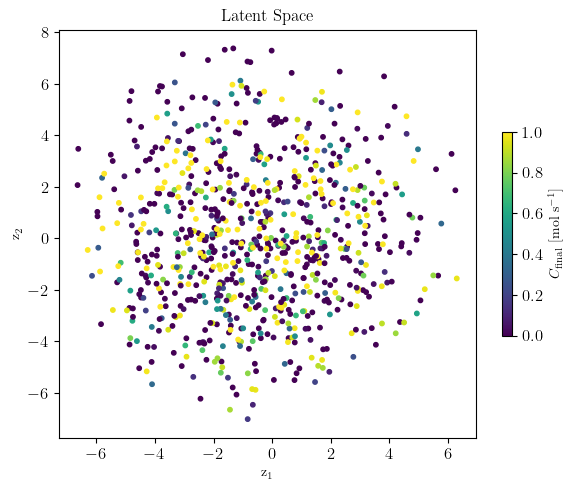

In [14]:
fig = plt.figure(figsize=(6, 5))

# Original
ax1 = fig.add_subplot(111)
sc2 = ax1.scatter(z_latent[:, 0], z_latent[:, 1], c=Z_vals, cmap='viridis', s=10)
ax1.set_title('Latent Space')
ax1.set_xlabel('z$_{1}$')
ax1.set_ylabel('z$_{2}$')
fig.colorbar(sc1, ax=ax1, label=r'$C_{\text{final}}$ [mol s$^{-1}$]', pad=0.05, shrink = 0.5 )
plt.tight_layout()
plt.show()

C:\Users\gabo1\AppData\Local\Temp\ipykernel_6160\396809658.py:13: UserWarning: Adding colorbar to a different Figure <Figure size 1200x500 with 2 Axes> than <Figure size 1200x500 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(sc1, ax=ax1, label=r'$C_{\text{final}}$ [mol s$^{-1}$]', pad=0.05, shrink = 0.5 )


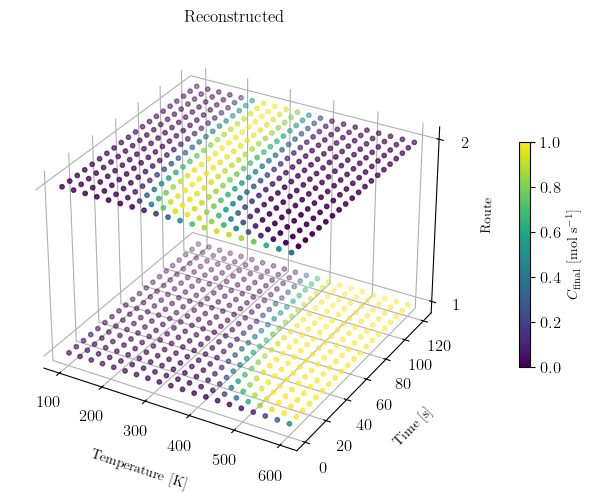

In [15]:

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(111, projection='3d')
sc3 = ax1.scatter(T_rec, Tau_rec, Ruta_rec, c=C_rec, cmap='viridis', s=10)
ax1.set_title('Reconstructed')
ax1.set_xlabel('Temperature [K]', labelpad=10)
ax1.set_ylabel('Time [s]', labelpad=10)
ax1.set_zlabel('Route', labelpad=2)
ax1.set_zticks([1,2])
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
fig.colorbar(sc1, ax=ax1, label=r'$C_{\text{final}}$ [mol s$^{-1}$]', pad=0.05, shrink = 0.5 )
plt.tight_layout()
plt.show()